# Fit logistic regression model

- based on different imputation methods
- baseline: reference
- model: any other selected imputation method

In [1]:
import logging
from pathlib import Path
from typing import List

import matplotlib.pyplot as plt
import njab.sklearn
import pandas as pd
import sklearn
from njab.plotting.metrics import plot_split_auc, plot_split_prc
from njab.sklearn.types import Splits

import vaep
import vaep.analyzers
import vaep.io.datasplits

plt.rcParams['figure.figsize'] = (2.5, 2.5)
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['lines.markersize'] = 2
fontsize = 5
figsize = (2.5, 2.5)
vaep.plotting.make_large_descriptors(fontsize)


logger = vaep.logging.setup_nb_logger()
logging.getLogger('fontTools').setLevel(logging.ERROR)


def parse_roc(*res: List[njab.sklearn.types.Results]) -> pd.DataFrame:
    ret = list()
    for _r in res:
        _roc = (pd.DataFrame(_r.test.roc,
                             index='fpr tpr cutoffs'.split()
                             )).loc[['fpr', 'tpr']]
        _roc = _roc.T
        _roc.columns = pd.MultiIndex.from_product([[_r.name], _roc.columns])
        ret.append(_roc)
    ret = pd.concat(ret, axis=1)
    return ret


def parse_prc(*res: List[njab.sklearn.types.Results]) -> pd.DataFrame:
    ret = list()
    for _r in res:
        _prc = pd.DataFrame(_r.test.prc,
                            index='precision recall cutoffs'.split()
                            ).loc[['precision', 'recall']]
        _prc = _prc.T.rename(columns={'recall': 'tpr'})
        _prc.columns = pd.MultiIndex.from_product([[_r.name], _prc.columns])
        ret.append(_prc)
    ret = pd.concat(ret, axis=1)
    return ret


# catch passed parameters
args = None
args = dict(globals()).keys()

## Parameters
Default and set parameters for the notebook.

In [2]:
folder_data: str = ''  # specify data directory if needed
fn_clinical_data = "data/ALD_study/processed/ald_metadata_cli.csv"
folder_experiment = "runs/appl_ald_data/plasma/proteinGroups"
model_key = 'VAE'
target = 'kleiner'
sample_id_col = 'Sample ID'
cutoff_target: int = 2  # => for binarization target >= cutoff_target
file_format = "csv"
out_folder = 'diff_analysis'
fn_qc_samples = ''  # 'data/ALD_study/processed/qc_plasma_proteinGroups.pkl'

baseline = 'RSN'  # default is RSN, as this was used in the original ALD Niu. et. al 2022
template_pred = 'pred_real_na_{}.csv'  # fixed, do not change

In [3]:
# Parameters
cutoff_target = 0.5
folder_experiment = "runs/alzheimer_study"
target = "AD"
baseline = "PI"
model_key = "RF"
out_folder = "diff_analysis"
fn_clinical_data = "runs/alzheimer_study/data/clinical_data.csv"


In [4]:
params = vaep.nb.get_params(args, globals=globals())
args = vaep.nb.Config()
args.folder_experiment = Path(params["folder_experiment"])
args = vaep.nb.add_default_paths(args,
                                 out_root=(args.folder_experiment
                                           / params["out_folder"]
                                           / params["target"]
                                           / f"{params['baseline']}_vs_{params['model_key']}"))
args.update_from_dict(params)
files_out = dict()
args

root - INFO     Removed from global namespace: folder_data


root - INFO     Removed from global namespace: fn_clinical_data


root - INFO     Removed from global namespace: folder_experiment


root - INFO     Removed from global namespace: model_key


root - INFO     Removed from global namespace: target


root - INFO     Removed from global namespace: sample_id_col


root - INFO     Removed from global namespace: cutoff_target


root - INFO     Removed from global namespace: file_format


root - INFO     Removed from global namespace: out_folder


root - INFO     Removed from global namespace: fn_qc_samples


root - INFO     Removed from global namespace: baseline


root - INFO     Removed from global namespace: template_pred


root - INFO     Already set attribute: folder_experiment has value runs/alzheimer_study


root - INFO     Already set attribute: out_folder has value diff_analysis


{'baseline': 'PI',
 'cutoff_target': 0.5,
 'data': PosixPath('runs/alzheimer_study/data'),
 'file_format': 'csv',
 'fn_clinical_data': 'runs/alzheimer_study/data/clinical_data.csv',
 'fn_qc_samples': '',
 'folder_data': '',
 'folder_experiment': PosixPath('runs/alzheimer_study'),
 'model_key': 'RF',
 'out_figures': PosixPath('runs/alzheimer_study/figures'),
 'out_folder': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_RF'),
 'out_metrics': PosixPath('runs/alzheimer_study'),
 'out_models': PosixPath('runs/alzheimer_study'),
 'out_preds': PosixPath('runs/alzheimer_study/preds'),
 'sample_id_col': 'Sample ID',
 'target': 'AD',
 'template_pred': 'pred_real_na_{}.csv'}

## Load data

### Load target

In [5]:
target = pd.read_csv(args.fn_clinical_data,
                     index_col=0,
                     usecols=[args.sample_id_col, args.target])
target = target.dropna()
target

,AD
Sample ID,
Sample_000,0
Sample_001,1
Sample_002,1
Sample_003,1
Sample_004,1
...,...
Sample_205,1
Sample_206,0
Sample_207,0


### MS proteomics or specified omics data
Aggregated from data splits of the imputation workflow run before.

In [6]:
data = vaep.io.datasplits.DataSplits.from_folder(
    args.data, file_format=args.file_format)
data = pd.concat([data.train_X, data.val_y, data.test_y])
data.sample(5)

vaep.io.datasplits - INFO     Loaded 'train_X' from file: runs/alzheimer_study/data/train_X.csv


vaep.io.datasplits - INFO     Loaded 'val_y' from file: runs/alzheimer_study/data/val_y.csv


vaep.io.datasplits - INFO     Loaded 'test_y' from file: runs/alzheimer_study/data/test_y.csv


Sample ID   protein groups
Sample_108  Q99523           17.149
Sample_201  P69905           16.806
Sample_177  P01023           23.462
Sample_041  P01011           24.744
Sample_005  A0A087WSY6       20.796
Name: intensity, dtype: float64

Get overlap between independent features and target

### Select by ALD criteria
Use parameters as specified in [ALD study](https://github.com/RasmussenLab/pimms/tree/main/project/data/ALD_study).

In [7]:
DATA_COMPLETENESS = 0.6
MIN_N_PROTEIN_GROUPS: int = 200
FRAC_PROTEIN_GROUPS: int = 0.622
CV_QC_SAMPLE: float = 0.4

ald_study, cutoffs = vaep.analyzers.diff_analysis.select_raw_data(data.unstack(
), data_completeness=DATA_COMPLETENESS, frac_protein_groups=FRAC_PROTEIN_GROUPS)

if args.fn_qc_samples:
    qc_samples = pd.read_pickle(args.fn_qc_samples)
    qc_samples = qc_samples[ald_study.columns]
    qc_cv_feat = qc_samples.std() / qc_samples.mean()
    qc_cv_feat = qc_cv_feat.rename(qc_samples.columns.name)
    fig, ax = plt.subplots(figsize=(4, 7))
    ax = qc_cv_feat.plot.box(ax=ax)
    ax.set_ylabel('Coefficient of Variation')
    print((qc_cv_feat < CV_QC_SAMPLE).value_counts())
    ald_study = ald_study[vaep.analyzers.diff_analysis.select_feat(qc_samples)]

column_name_first_prot_to_pg = {
    pg.split(';')[0]: pg for pg in data.unstack().columns}

ald_study = ald_study.rename(columns=column_name_first_prot_to_pg)
ald_study

root - INFO     Initally: N samples: 210, M feat: 1421


root - INFO     Dropped features quantified in less than 126 samples.


root - INFO     After feat selection: N samples: 210, M feat: 1213


root - INFO     Min No. of Protein-Groups in single sample: 754


root - INFO     Finally: N samples: 210, M feat: 1213


protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,A0A075B6J9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,20.246,16.764,17.584,16.988,20.054,NaN,...,16.012,15.178,NaN,15.050,16.842,19.863,NaN,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,19.941,18.786,17.144,NaN,19.067,16.188,...,15.528,15.576,NaN,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,19.251,16.832,15.671,17.012,18.569,NaN,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,19.628,17.852,18.877,14.182,18.985,13.438,...,15.495,14.590,14.682,15.140,17.356,19.429,NaN,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,20.450,18.682,17.081,14.140,19.686,14.495,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,17.705,17.039,NaN,16.413,19.102,16.064,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,18.154,18.152,16.503,16.860,18.538,15.288,...,15.422,16.106,NaN,15.345,17.084,18.708,14.249,19.433,NaN,NaN
Sample_207,15.739,16.877,15.469,16.898,18.636,17.950,16.321,16.401,18.849,17.580,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


Number of complete cases which can be used:

In [8]:
mask_has_target = data.index.levels[0].intersection(target.index)
assert not mask_has_target.empty, f"No data for target: {data.index.levels[0]} and {target.index}"
print(
    f"Samples available both in proteomics data and for target: {len(mask_has_target)}")
target, data, ald_study = target.loc[mask_has_target], data.loc[mask_has_target], ald_study.loc[mask_has_target]

Samples available both in proteomics data and for target: 210


### Load imputations from specified model

In [9]:
fname = args.out_preds / args.template_pred.format(args.model_key)
print(f"missing values pred. by {args.model_key}: {fname}")
load_single_csv_pred_file = vaep.analyzers.compare_predictions.load_single_csv_pred_file
pred_real_na = load_single_csv_pred_file(fname).loc[mask_has_target]
pred_real_na.sample(3)

missing values pred. by RF: runs/alzheimer_study/preds/pred_real_na_RF.csv


Sample ID   protein groups
Sample_053  Q5SPY9;Q9NQX5    15.662
Sample_147  P31151           11.147
Sample_055  F2Z2C8;Q9BVH7    13.339
Name: intensity, dtype: float64

### Load imputations from baseline model

In [10]:
fname = args.out_preds / args.template_pred.format(args.baseline)
pred_real_na_baseline = load_single_csv_pred_file(fname)  # .loc[mask_has_target]
pred_real_na_baseline

Sample ID   protein groups          
Sample_000  A0A075B6J9                 14.040
            A0A075B6Q5                 11.510
            A0A075B6R2                 13.398
            A0A075B6S5                 13.170
            A0A087WSY4                 13.008
                                        ...  
Sample_209  Q9P1W8;Q9P1W8-2;Q9P1W8-4   12.529
            Q9UI40;Q9UI40-2            12.512
            Q9UIW2                     12.332
            Q9UMX0;Q9UMX0-2;Q9UMX0-4   13.099
            Q9UP79                     12.511
Name: intensity, Length: 46401, dtype: float64

## Modeling setup
General approach:
  - use one train, test split of the data
  - select best 10 features from training data `X_train`, `y_train` before binarization of target
  - dichotomize (binarize) data into to groups (zero and 1)
  - evaluate model on the test data `X_test`, `y_test`

Repeat general approach for
 1. all original ald data: all features justed in original ALD study
 2. all model data: all features available my using the self supervised deep learning model
 3. newly available feat only: the subset of features available from the
    self supervised deep learning model which were newly retained using the
    new approach

All data:

In [11]:
X = pd.concat([data, pred_real_na]).unstack()
X

protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H7,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,17.301,20.246,16.764,17.584,16.988,20.054,...,16.012,15.178,14.475,15.050,16.842,19.863,15.632,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,13.796,19.941,18.786,17.144,16.618,19.067,...,15.528,15.576,14.261,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,18.175,19.251,16.832,15.671,17.012,18.569,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,15.963,19.628,17.852,18.877,14.182,18.985,...,15.495,14.590,14.682,15.140,17.356,19.429,15.644,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,15.473,20.450,18.682,17.081,14.140,19.686,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,15.387,17.705,17.039,16.587,16.413,19.102,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,15.837,18.154,18.152,16.503,16.860,18.538,...,15.422,16.106,14.463,15.345,17.084,18.708,14.249,19.433,12.317,11.281
Sample_207,15.739,16.877,15.469,16.898,15.983,18.636,17.950,16.321,16.401,18.849,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


### Subset of data by ALD criteria

In [12]:
# could be just observed, drop columns with missing values
ald_study = pd.concat(
    [ald_study.stack(),
     pred_real_na_baseline.loc[
        # only select columns in selected in ald_study
        pd.IndexSlice[:, pred_real_na.index.levels[-1].intersection(ald_study.columns)]
    ]
    ]
).unstack()
ald_study

protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,A0A075B6J9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,20.246,16.764,17.584,16.988,20.054,14.040,...,16.012,15.178,12.091,15.050,16.842,19.863,12.053,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,19.941,18.786,17.144,13.465,19.067,16.188,...,15.528,15.576,12.538,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,19.251,16.832,15.671,17.012,18.569,12.797,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,19.628,17.852,18.877,14.182,18.985,13.438,...,15.495,14.590,14.682,15.140,17.356,19.429,13.458,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,20.450,18.682,17.081,14.140,19.686,14.495,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,17.705,17.039,12.201,16.413,19.102,16.064,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,18.154,18.152,16.503,16.860,18.538,15.288,...,15.422,16.106,12.764,15.345,17.084,18.708,14.249,19.433,12.335,13.982
Sample_207,15.739,16.877,15.469,16.898,18.636,17.950,16.321,16.401,18.849,17.580,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


Features which would not have been included using ALD criteria:

In [13]:
new_features = X.columns.difference(ald_study.columns)
new_features

Index(['A0A075B6H7', 'A0A075B6Q5', 'A0A075B7B8', 'A0A087WSY4',
       'A0A087WTT8;A0A0A0MQX5;O94779;O94779-2', 'A0A087WXB8;Q9Y274',
       'A0A087WXE9;E9PQ70;Q6UXH9;Q6UXH9-2;Q6UXH9-3',
       'A0A087X1Z2;C9JTV4;H0Y4Y4;Q8WYH2;Q96C19;Q9BUP0;Q9BUP0-2',
       'A0A0A0MQS9;A0A0A0MTC7;Q16363;Q16363-2', 'A0A0A0MSN4;P12821;P12821-2',
       ...
       'Q9NZ94;Q9NZ94-2;Q9NZ94-3', 'Q9NZU1', 'Q9P1W8;Q9P1W8-2;Q9P1W8-4',
       'Q9UHI8', 'Q9UI40;Q9UI40-2',
       'Q9UIB8;Q9UIB8-2;Q9UIB8-3;Q9UIB8-4;Q9UIB8-5;Q9UIB8-6',
       'Q9UKZ4;Q9UKZ4-2', 'Q9UMX0;Q9UMX0-2;Q9UMX0-4', 'Q9Y281;Q9Y281-3',
       'Q9Y490'],
      dtype='object', name='protein groups', length=208)

Binarize targets, but also keep groups for stratification

In [14]:
target_to_group = target.copy()
target = target >= args.cutoff_target
pd.crosstab(target.squeeze(), target_to_group.squeeze())

AD,0,1
AD,,
False,122,0
True,0,88


## Determine best number of parameters by cross validation procedure

using subset of data by ALD criteria:

In [15]:
cv_feat_ald = njab.sklearn.find_n_best_features(X=ald_study, y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_ald = (cv_feat_ald
               .drop('test_case', axis=1)
               .groupby('n_features')
               .agg(['mean', 'std']))
cv_feat_ald

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 376.95it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00,  3.82it/s]

100%|██████████| 2/2 [00:00<00:00,  3.74it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 67%|██████▋   | 2/3 [00:00<00:00,  5.63it/s]

100%|██████████| 3/3 [00:00<00:00,  3.15it/s]

100%|██████████| 3/3 [00:00<00:00,  3.42it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  3.72it/s]

 75%|███████▌  | 3/4 [00:01<00:00,  2.75it/s]

100%|██████████| 4/4 [00:01<00:00,  2.43it/s]

100%|██████████| 4/4 [00:01<00:00,  2.60it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 40%|████      | 2/5 [00:00<00:00,  4.13it/s]

 60%|██████    | 3/5 [00:00<00:00,  2.92it/s]

 80%|████████  | 4/5 [00:01<00:00,  2.88it/s]

100%|██████████| 5/5 [00:01<00:00,  2.82it/s]

100%|██████████| 5/5 [00:01<00:00,  2.95it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 33%|███▎      | 2/6 [00:00<00:00,  4.91it/s]

 50%|█████     | 3/6 [00:00<00:00,  3.65it/s]

 67%|██████▋   | 4/6 [00:01<00:00,  3.25it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  2.75it/s]

100%|██████████| 6/6 [00:02<00:00,  2.59it/s]

100%|██████████| 6/6 [00:02<00:00,  2.93it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 29%|██▊       | 2/7 [00:00<00:00,  5.06it/s]

 43%|████▎     | 3/7 [00:00<00:01,  3.68it/s]

 57%|█████▋    | 4/7 [00:01<00:00,  3.16it/s]

 71%|███████▏  | 5/7 [00:01<00:00,  2.85it/s]

 86%|████████▌ | 6/7 [00:01<00:00,  2.70it/s]

100%|██████████| 7/7 [00:02<00:00,  2.75it/s]

100%|██████████| 7/7 [00:02<00:00,  3.00it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 25%|██▌       | 2/8 [00:00<00:01,  5.23it/s]

 38%|███▊      | 3/8 [00:00<00:01,  3.70it/s]

 50%|█████     | 4/8 [00:01<00:01,  3.25it/s]

 62%|██████▎   | 5/8 [00:01<00:00,  3.06it/s]

 75%|███████▌  | 6/8 [00:01<00:00,  2.97it/s]

 88%|████████▊ | 7/8 [00:02<00:00,  3.03it/s]

100%|██████████| 8/8 [00:02<00:00,  3.09it/s]

100%|██████████| 8/8 [00:02<00:00,  3.23it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 22%|██▏       | 2/9 [00:00<00:01,  6.40it/s]

 33%|███▎      | 3/9 [00:00<00:01,  4.15it/s]

 44%|████▍     | 4/9 [00:01<00:01,  3.58it/s]

 56%|█████▌    | 5/9 [00:01<00:01,  3.22it/s]

 67%|██████▋   | 6/9 [00:01<00:01,  2.75it/s]

 78%|███████▊  | 7/9 [00:02<00:00,  2.48it/s]

 89%|████████▉ | 8/9 [00:02<00:00,  2.32it/s]

100%|██████████| 9/9 [00:03<00:00,  2.20it/s]

100%|██████████| 9/9 [00:03<00:00,  2.68it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:01,  5.59it/s]

 30%|███       | 3/10 [00:00<00:01,  3.51it/s]

 40%|████      | 4/10 [00:01<00:02,  2.94it/s]

 50%|█████     | 5/10 [00:01<00:02,  2.44it/s]

 60%|██████    | 6/10 [00:02<00:01,  2.45it/s]

 70%|███████   | 7/10 [00:02<00:01,  2.58it/s]

 80%|████████  | 8/10 [00:02<00:00,  2.68it/s]

 90%|█████████ | 9/10 [00:03<00:00,  2.84it/s]

100%|██████████| 10/10 [00:03<00:00,  2.35it/s]

100%|██████████| 10/10 [00:03<00:00,  2.66it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:01,  5.49it/s]

 27%|██▋       | 3/11 [00:00<00:02,  3.92it/s]

 36%|███▋      | 4/11 [00:01<00:02,  3.36it/s]

 45%|████▌     | 5/11 [00:01<00:01,  3.10it/s]

 55%|█████▍    | 6/11 [00:01<00:01,  3.03it/s]

 64%|██████▎   | 7/11 [00:02<00:01,  3.07it/s]

 73%|███████▎  | 8/11 [00:02<00:00,  3.21it/s]

 82%|████████▏ | 9/11 [00:02<00:00,  3.23it/s]

 91%|█████████ | 10/11 [00:03<00:00,  3.27it/s]

100%|██████████| 11/11 [00:03<00:00,  3.16it/s]

100%|██████████| 11/11 [00:03<00:00,  3.28it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:01,  6.13it/s]

 25%|██▌       | 3/12 [00:00<00:01,  4.51it/s]

 33%|███▎      | 4/12 [00:00<00:01,  4.18it/s]

 42%|████▏     | 5/12 [00:01<00:01,  4.03it/s]

 50%|█████     | 6/12 [00:01<00:01,  3.96it/s]

 58%|█████▊    | 7/12 [00:01<00:01,  3.57it/s]

 67%|██████▋   | 8/12 [00:02<00:01,  3.54it/s]

 75%|███████▌  | 9/12 [00:02<00:00,  3.42it/s]

 83%|████████▎ | 10/12 [00:02<00:00,  3.48it/s]

 92%|█████████▏| 11/12 [00:02<00:00,  3.49it/s]

100%|██████████| 12/12 [00:03<00:00,  3.34it/s]

100%|██████████| 12/12 [00:03<00:00,  3.69it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:01,  6.26it/s]

 23%|██▎       | 3/13 [00:00<00:02,  4.47it/s]

 31%|███       | 4/13 [00:01<00:02,  3.54it/s]

 38%|███▊      | 5/13 [00:01<00:02,  3.37it/s]

 46%|████▌     | 6/13 [00:01<00:02,  3.41it/s]

 54%|█████▍    | 7/13 [00:01<00:01,  3.19it/s]

 62%|██████▏   | 8/13 [00:02<00:01,  3.31it/s]

 69%|██████▉   | 9/13 [00:02<00:01,  3.39it/s]

 77%|███████▋  | 10/13 [00:02<00:00,  3.30it/s]

 85%|████████▍ | 11/13 [00:03<00:00,  3.17it/s]

 92%|█████████▏| 12/13 [00:03<00:00,  3.08it/s]

100%|██████████| 13/13 [00:03<00:00,  3.19it/s]

100%|██████████| 13/13 [00:03<00:00,  3.39it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:02,  4.49it/s]

 21%|██▏       | 3/14 [00:00<00:03,  3.61it/s]

 29%|██▊       | 4/14 [00:01<00:02,  3.47it/s]

 36%|███▌      | 5/14 [00:01<00:02,  3.21it/s]

 43%|████▎     | 6/14 [00:01<00:02,  3.27it/s]

 50%|█████     | 7/14 [00:02<00:02,  3.22it/s]

 57%|█████▋    | 8/14 [00:02<00:01,  3.21it/s]

 64%|██████▍   | 9/14 [00:02<00:01,  3.15it/s]

 71%|███████▏  | 10/14 [00:03<00:01,  3.22it/s]

 79%|███████▊  | 11/14 [00:03<00:01,  2.62it/s]

 86%|████████▌ | 12/14 [00:04<00:00,  2.23it/s]

 93%|█████████▎| 13/14 [00:04<00:00,  2.05it/s]

100%|██████████| 14/14 [00:05<00:00,  1.97it/s]

100%|██████████| 14/14 [00:05<00:00,  2.64it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:03,  3.91it/s]

 20%|██        | 3/15 [00:00<00:03,  3.16it/s]

 27%|██▋       | 4/15 [00:01<00:03,  3.03it/s]

 33%|███▎      | 5/15 [00:01<00:03,  3.05it/s]

 40%|████      | 6/15 [00:01<00:02,  3.08it/s]

 47%|████▋     | 7/15 [00:02<00:02,  3.09it/s]

 53%|█████▎    | 8/15 [00:02<00:02,  3.14it/s]

 60%|██████    | 9/15 [00:02<00:01,  3.20it/s]

 67%|██████▋   | 10/15 [00:03<00:01,  3.18it/s]

 73%|███████▎  | 11/15 [00:03<00:01,  3.25it/s]

 80%|████████  | 12/15 [00:03<00:01,  2.73it/s]

 87%|████████▋ | 13/15 [00:04<00:00,  2.48it/s]

 93%|█████████▎| 14/15 [00:04<00:00,  2.33it/s]

100%|██████████| 15/15 [00:05<00:00,  2.31it/s]

100%|██████████| 15/15 [00:05<00:00,  2.79it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.003 0.000      0.044 0.013          0.687 0.393       0.100   
2             0.007 0.005      0.075 0.028          0.632 0.146       0.457   
3             0.005 0.004      0.064 0.027          0.798 0.079       0.713   
4             0.004 0.001      0.053 0.014          0.804 0.078       0.767   
5             0.004 0.000      0.052 0.013          0.828 0.081       0.793   
6             0.004 0.000      0.048 0.004          0.825 0.087       0.790   
7             0.006 0.006      0.055 0.019          0.829 0.074       0.836   
8             0.005 0.003      0.056 0.017          0.828 0.077       0.830   
9             0.006 0.006      0.068 0.028          0.832 0.076       0.823   
10            0.007 0.006      0.073 0.026          0.832 0.075       0.822   
11            0.005 0.003      0.066 0.027          0.842 0.079       0.808   
12            0.006 0.004      0.062 0.024          0.840 0.078       0.806   
13            0.009 0.007      0.079 0.026          0.829 0.084       0.806   
14            0.008 0.009      0.064 0.025          0.822 0.088       0.793   
15            0.007 0.005      0.076 0.031          0.819 0.086       0.786   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.085   0.168 0.130                  0.542 0.042        0.846   
2          0.113   0.519 0.097                  0.624 0.066        0.698   
3          0.105   0.747 0.069                  0.789 0.055        0.896   
4          0.109   0.780 0.071                  0.814 0.059        0.904   
5          0.096   0.806 0.065                  0.834 0.055        0.910   
6          0.094   0.803 0.066                  0.831 0.057        0.909   
7          0.101   0.829 0.068                  0.854 0.059        0.921   
8          0.102   0.825 0.071                  0.851 0.061        0.918   
9          0.100   0.824 0.068                  0.850 0.059        0.919   
10         0.100   0.823 0.068                  0.850 0.058        0.918   
11         0.096   0.821 0.069                  0.848 0.058        0.924   
12         0.097   0.819 0.067                  0.846 0.057        0.922   
13         0.100   0.813 0.069                  0.841 0.059        0.919   
14         0.103   0.802 0.074                  0.832 0.061        0.917   
15         0.103   0.797 0.072                  0.828 0.060        0.916   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.066                  0.821 0.088        210.000 0.000  
2          0.083                  0.652 0.098        210.000 0.000  
3          0.044                  0.871 0.057        210.000 0.000  
4          0.045                  0.882 0.055        210.000 0.000  
5          0.047                  0.894 0.054        210.000 0.000  
6          0.048                  0.894 0.056        210.000 0.000  
7          0.043                  0.911 0.045        210.000 0.000  
8          0.045                  0.906 0.049        210.000 0.000  
9          0.045                  0.908 0.049        210.000 0.000  
10         0.044                  0.908 0.048        210.000 0.000  
11         0.046                  0.915 0.049        210.000 0.000  
12         0.047                  0.913 0.049        210.000 0.000  
13         0.048                  0.910 0.049        210.000 0.000  
14         0.048                  0.909 0.049        210.000 0.000  
15         0.048                  0.907 0.048 

Using all data:

In [16]:
cv_feat_all = njab.sklearn.find_n_best_features(X=X, y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_all = cv_feat_all.drop('test_case', axis=1).groupby('n_features').agg(['mean', 'std'])
cv_feat_all

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 276.18it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00,  5.56it/s]

100%|██████████| 2/2 [00:00<00:00,  5.51it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 67%|██████▋   | 2/3 [00:00<00:00,  5.66it/s]

100%|██████████| 3/3 [00:00<00:00,  4.02it/s]

100%|██████████| 3/3 [00:00<00:00,  4.25it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  4.80it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  3.42it/s]

100%|██████████| 4/4 [00:01<00:00,  3.05it/s]

100%|██████████| 4/4 [00:01<00:00,  3.28it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 40%|████      | 2/5 [00:00<00:00,  4.84it/s]

 60%|██████    | 3/5 [00:00<00:00,  3.55it/s]

 80%|████████  | 4/5 [00:01<00:00,  2.89it/s]

100%|██████████| 5/5 [00:01<00:00,  2.73it/s]

100%|██████████| 5/5 [00:01<00:00,  3.01it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 33%|███▎      | 2/6 [00:00<00:00,  4.94it/s]

 50%|█████     | 3/6 [00:00<00:00,  3.58it/s]

 67%|██████▋   | 4/6 [00:01<00:00,  3.00it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  2.76it/s]

100%|██████████| 6/6 [00:02<00:00,  2.73it/s]

100%|██████████| 6/6 [00:02<00:00,  2.98it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 29%|██▊       | 2/7 [00:00<00:00,  5.13it/s]

 43%|████▎     | 3/7 [00:00<00:01,  3.73it/s]

 57%|█████▋    | 4/7 [00:01<00:00,  3.23it/s]

 71%|███████▏  | 5/7 [00:01<00:00,  2.87it/s]

 86%|████████▌ | 6/7 [00:01<00:00,  2.73it/s]

100%|██████████| 7/7 [00:02<00:00,  2.63it/s]

100%|██████████| 7/7 [00:02<00:00,  2.95it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 25%|██▌       | 2/8 [00:00<00:01,  3.52it/s]

 38%|███▊      | 3/8 [00:01<00:02,  2.17it/s]

 50%|█████     | 4/8 [00:01<00:01,  2.08it/s]

 62%|██████▎   | 5/8 [00:02<00:01,  2.10it/s]

 75%|███████▌  | 6/8 [00:02<00:00,  2.22it/s]

 88%|████████▊ | 7/8 [00:03<00:00,  2.38it/s]

100%|██████████| 8/8 [00:03<00:00,  2.48it/s]

100%|██████████| 8/8 [00:03<00:00,  2.37it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 22%|██▏       | 2/9 [00:00<00:01,  5.16it/s]

 33%|███▎      | 3/9 [00:00<00:01,  3.68it/s]

 44%|████▍     | 4/9 [00:01<00:01,  2.73it/s]

 56%|█████▌    | 5/9 [00:01<00:01,  2.33it/s]

 67%|██████▋   | 6/9 [00:02<00:01,  1.98it/s]

 78%|███████▊  | 7/9 [00:02<00:01,  2.00it/s]

 89%|████████▉ | 8/9 [00:03<00:00,  2.04it/s]

100%|██████████| 9/9 [00:03<00:00,  2.14it/s]

100%|██████████| 9/9 [00:03<00:00,  2.32it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:01,  5.70it/s]

 30%|███       | 3/10 [00:00<00:01,  3.77it/s]

 40%|████      | 4/10 [00:01<00:01,  3.37it/s]

 50%|█████     | 5/10 [00:01<00:02,  2.37it/s]

 60%|██████    | 6/10 [00:02<00:01,  2.24it/s]

 70%|███████   | 7/10 [00:02<00:01,  2.05it/s]

 80%|████████  | 8/10 [00:03<00:00,  2.09it/s]

 90%|█████████ | 9/10 [00:03<00:00,  2.25it/s]

100%|██████████| 10/10 [00:04<00:00,  2.28it/s]

100%|██████████| 10/10 [00:04<00:00,  2.45it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:02,  4.24it/s]

 27%|██▋       | 3/11 [00:00<00:02,  3.59it/s]

 36%|███▋      | 4/11 [00:01<00:02,  3.21it/s]

 45%|████▌     | 5/11 [00:01<00:02,  2.43it/s]

 55%|█████▍    | 6/11 [00:02<00:02,  2.15it/s]

 64%|██████▎   | 7/11 [00:02<00:02,  1.97it/s]

 73%|███████▎  | 8/11 [00:03<00:01,  2.01it/s]

 82%|████████▏ | 9/11 [00:03<00:00,  2.10it/s]

 91%|█████████ | 10/11 [00:04<00:00,  2.17it/s]

100%|██████████| 11/11 [00:04<00:00,  2.26it/s]

100%|██████████| 11/11 [00:04<00:00,  2.35it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:01,  5.36it/s]

 25%|██▌       | 3/12 [00:00<00:02,  3.71it/s]

 33%|███▎      | 4/12 [00:01<00:02,  3.26it/s]

 42%|████▏     | 5/12 [00:01<00:02,  3.08it/s]

 50%|█████     | 6/12 [00:01<00:02,  2.67it/s]

 58%|█████▊    | 7/12 [00:02<00:02,  2.32it/s]

 67%|██████▋   | 8/12 [00:03<00:01,  2.05it/s]

 75%|███████▌  | 9/12 [00:03<00:01,  2.05it/s]

 83%|████████▎ | 10/12 [00:04<00:00,  2.14it/s]

 92%|█████████▏| 11/12 [00:04<00:00,  1.90it/s]

100%|██████████| 12/12 [00:05<00:00,  1.67it/s]

100%|██████████| 12/12 [00:05<00:00,  2.20it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:02,  5.24it/s]

 23%|██▎       | 3/13 [00:00<00:02,  3.71it/s]

 31%|███       | 4/13 [00:01<00:02,  3.25it/s]

 38%|███▊      | 5/13 [00:01<00:02,  3.11it/s]

 46%|████▌     | 6/13 [00:01<00:02,  3.00it/s]

 54%|█████▍    | 7/13 [00:02<00:02,  2.87it/s]

 62%|██████▏   | 8/13 [00:02<00:02,  2.45it/s]

 69%|██████▉   | 9/13 [00:03<00:01,  2.19it/s]

 77%|███████▋  | 10/13 [00:03<00:01,  2.05it/s]

 85%|████████▍ | 11/13 [00:04<00:01,  1.88it/s]

 92%|█████████▏| 12/13 [00:05<00:00,  1.72it/s]

100%|██████████| 13/13 [00:05<00:00,  1.71it/s]

100%|██████████| 13/13 [00:05<00:00,  2.24it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:02,  5.71it/s]

 21%|██▏       | 3/14 [00:00<00:02,  4.10it/s]

 29%|██▊       | 4/14 [00:01<00:02,  3.53it/s]

 36%|███▌      | 5/14 [00:01<00:02,  3.19it/s]

 43%|████▎     | 6/14 [00:01<00:02,  3.01it/s]

 50%|█████     | 7/14 [00:02<00:02,  2.90it/s]

 57%|█████▋    | 8/14 [00:02<00:02,  2.82it/s]

 64%|██████▍   | 9/14 [00:02<00:01,  2.82it/s]

 71%|███████▏  | 10/14 [00:03<00:01,  2.42it/s]

 79%|███████▊  | 11/14 [00:03<00:01,  2.17it/s]

 86%|████████▌ | 12/14 [00:04<00:01,  1.86it/s]

 93%|█████████▎| 13/14 [00:05<00:00,  1.65it/s]

100%|██████████| 14/14 [00:06<00:00,  1.59it/s]

100%|██████████| 14/14 [00:06<00:00,  2.27it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:03,  3.41it/s]

 20%|██        | 3/15 [00:00<00:04,  2.95it/s]

 27%|██▋       | 4/15 [00:01<00:03,  2.88it/s]

 33%|███▎      | 5/15 [00:01<00:03,  2.83it/s]

 40%|████      | 6/15 [00:02<00:03,  2.73it/s]

 47%|████▋     | 7/15 [00:02<00:03,  2.60it/s]

 53%|█████▎    | 8/15 [00:02<00:02,  2.68it/s]

 60%|██████    | 9/15 [00:03<00:02,  2.65it/s]

 67%|██████▋   | 10/15 [00:03<00:01,  2.52it/s]

 73%|███████▎  | 11/15 [00:04<00:01,  2.35it/s]

 80%|████████  | 12/15 [00:04<00:01,  2.14it/s]

 87%|████████▋ | 13/15 [00:05<00:01,  1.97it/s]

 93%|█████████▎| 14/15 [00:05<00:00,  1.87it/s]

100%|██████████| 15/15 [00:06<00:00,  1.73it/s]

100%|██████████| 15/15 [00:06<00:00,  2.26it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.005 0.004      0.070 0.026          0.000 0.000       0.000   
2             0.005 0.004      0.069 0.031          0.671 0.111       0.478   
3             0.006 0.006      0.068 0.033          0.746 0.102       0.582   
4             0.005 0.004      0.067 0.028          0.723 0.105       0.589   
5             0.007 0.006      0.072 0.027          0.801 0.095       0.733   
6             0.006 0.004      0.060 0.018          0.800 0.104       0.751   
7             0.005 0.003      0.056 0.019          0.800 0.106       0.750   
8             0.005 0.004      0.074 0.030          0.801 0.102       0.749   
9             0.007 0.008      0.076 0.036          0.783 0.094       0.799   
10            0.006 0.005      0.076 0.032          0.781 0.096       0.791   
11            0.006 0.005      0.078 0.031          0.806 0.083       0.805   
12            0.006 0.004      0.069 0.028          0.813 0.082       0.804   
13            0.005 0.003      0.064 0.026          0.835 0.097       0.798   
14            0.006 0.004      0.067 0.025          0.845 0.093       0.800   
15            0.007 0.008      0.075 0.029          0.840 0.095       0.797   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.000   0.000 0.000                  0.496 0.008        0.856   
2          0.121   0.545 0.088                  0.647 0.054        0.700   
3          0.116   0.647 0.093                  0.717 0.065        0.798   
4          0.119   0.641 0.091                  0.709 0.066        0.801   
5          0.119   0.759 0.082                  0.798 0.064        0.891   
6          0.118   0.768 0.085                  0.804 0.069        0.897   
7          0.114   0.768 0.084                  0.804 0.069        0.895   
8          0.111   0.768 0.080                  0.804 0.066        0.894   
9          0.110   0.784 0.073                  0.815 0.062        0.909   
10         0.120   0.779 0.080                  0.812 0.066        0.906   
11         0.107   0.800 0.070                  0.830 0.059        0.914   
12         0.106   0.803 0.068                  0.832 0.057        0.914   
13         0.115   0.809 0.078                  0.838 0.064        0.923   
14         0.108   0.815 0.072                  0.843 0.059        0.922   
15         0.110   0.812 0.074                  0.840 0.060        0.921   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.061                  0.824 0.086        210.000 0.000  
2          0.081                  0.634 0.099        210.000 0.000  
3          0.070                  0.777 0.087        210.000 0.000  
4          0.069                  0.774 0.088        210.000 0.000  
5          0.050                  0.868 0.060        210.000 0.000  
6          0.054                  0.874 0.064        210.000 0.000  
7          0.054                  0.872 0.064        210.000 0.000  
8          0.054                  0.871 0.064        210.000 0.000  
9          0.049                  0.887 0.057        210.000 0.000  
10         0.050                  0.884 0.059        210.000 0.000  
11         0.051                  0.895 0.057        210.000 0.000  
12         0.051                  0.896 0.057        210.000 0.000  
13         0.045                  0.903 0.053        210.000 0.000  
14         0.044                  0.903 0.052        210.000 0.000  
15         0.045                  0.901 0.052 

Using only new features:

In [17]:
cv_feat_new = njab.sklearn.find_n_best_features(X=X.loc[:, new_features],
                                                y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_new = cv_feat_new.drop('test_case', axis=1).groupby('n_features').agg(['mean', 'std'])
cv_feat_new

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 944.45it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00, 19.76it/s]

100%|██████████| 2/2 [00:00<00:00, 17.86it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 3/3 [00:00<00:00, 19.62it/s]

100%|██████████| 3/3 [00:00<00:00, 19.24it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00, 19.34it/s]

100%|██████████| 4/4 [00:00<00:00, 11.06it/s]

100%|██████████| 4/4 [00:00<00:00, 11.79it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 60%|██████    | 3/5 [00:00<00:00, 16.77it/s]

100%|██████████| 5/5 [00:00<00:00, 13.83it/s]

100%|██████████| 5/5 [00:00<00:00, 14.17it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 50%|█████     | 3/6 [00:00<00:00, 17.59it/s]

 83%|████████▎ | 5/6 [00:00<00:00, 13.12it/s]

100%|██████████| 6/6 [00:00<00:00, 13.56it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 43%|████▎     | 3/7 [00:00<00:00, 18.05it/s]

 71%|███████▏  | 5/7 [00:00<00:00, 15.79it/s]

100%|██████████| 7/7 [00:00<00:00, 14.27it/s]

100%|██████████| 7/7 [00:00<00:00, 14.83it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 25%|██▌       | 2/8 [00:00<00:00, 18.47it/s]

 50%|█████     | 4/8 [00:00<00:00, 12.58it/s]

 75%|███████▌  | 6/8 [00:00<00:00, 11.24it/s]

100%|██████████| 8/8 [00:00<00:00, 11.15it/s]

100%|██████████| 8/8 [00:00<00:00, 11.64it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 33%|███▎      | 3/9 [00:00<00:00, 18.14it/s]

 56%|█████▌    | 5/9 [00:00<00:00, 15.12it/s]

 78%|███████▊  | 7/9 [00:00<00:00, 14.26it/s]

100%|██████████| 9/9 [00:00<00:00, 14.24it/s]

100%|██████████| 9/9 [00:00<00:00, 14.61it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 30%|███       | 3/10 [00:00<00:00, 13.49it/s]

 50%|█████     | 5/10 [00:00<00:00, 12.29it/s]

 70%|███████   | 7/10 [00:00<00:00, 11.93it/s]

 90%|█████████ | 9/10 [00:00<00:00, 11.22it/s]

100%|██████████| 10/10 [00:00<00:00, 11.92it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 27%|██▋       | 3/11 [00:00<00:00, 20.67it/s]

 55%|█████▍    | 6/11 [00:00<00:00, 15.97it/s]

 73%|███████▎  | 8/11 [00:00<00:00, 14.29it/s]

 91%|█████████ | 10/11 [00:00<00:00, 13.15it/s]

100%|██████████| 11/11 [00:00<00:00, 14.09it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:00, 13.19it/s]

 33%|███▎      | 4/12 [00:00<00:00, 12.90it/s]

 50%|█████     | 6/12 [00:00<00:00, 11.47it/s]

 67%|██████▋   | 8/12 [00:00<00:00, 11.07it/s]

 83%|████████▎ | 10/12 [00:00<00:00, 10.06it/s]

100%|██████████| 12/12 [00:01<00:00,  9.16it/s]

100%|██████████| 12/12 [00:01<00:00, 10.07it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 23%|██▎       | 3/13 [00:00<00:00, 14.32it/s]

 38%|███▊      | 5/13 [00:00<00:00, 11.03it/s]

 54%|█████▍    | 7/13 [00:00<00:00, 10.19it/s]

 69%|██████▉   | 9/13 [00:00<00:00, 10.00it/s]

 85%|████████▍ | 11/13 [00:01<00:00,  8.99it/s]

 92%|█████████▏| 12/13 [00:01<00:00,  8.70it/s]

100%|██████████| 13/13 [00:01<00:00,  8.62it/s]

100%|██████████| 13/13 [00:01<00:00,  9.40it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 21%|██▏       | 3/14 [00:00<00:00, 14.12it/s]

 36%|███▌      | 5/14 [00:00<00:00, 13.16it/s]

 50%|█████     | 7/14 [00:00<00:00, 13.11it/s]

 64%|██████▍   | 9/14 [00:00<00:00, 11.88it/s]

 79%|███████▊  | 11/14 [00:00<00:00, 10.78it/s]

 93%|█████████▎| 13/14 [00:01<00:00,  9.38it/s]

100%|██████████| 14/14 [00:01<00:00, 10.79it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:00, 19.91it/s]

 27%|██▋       | 4/15 [00:00<00:00, 11.66it/s]

 40%|████      | 6/15 [00:00<00:00,  9.75it/s]

 53%|█████▎    | 8/15 [00:00<00:00,  9.51it/s]

 67%|██████▋   | 10/15 [00:01<00:00,  9.41it/s]

 73%|███████▎  | 11/15 [00:01<00:00,  9.46it/s]

 80%|████████  | 12/15 [00:01<00:00,  8.63it/s]

 87%|████████▋ | 13/15 [00:01<00:00,  8.37it/s]

 93%|█████████▎| 14/15 [00:01<00:00,  8.18it/s]

100%|██████████| 15/15 [00:01<00:00,  8.23it/s]

100%|██████████| 15/15 [00:01<00:00,  9.16it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.005 0.004      0.057 0.020          0.000 0.000       0.000   
2             0.005 0.003      0.055 0.016          0.630 0.118       0.357   
3             0.005 0.003      0.061 0.023          0.641 0.087       0.490   
4             0.004 0.002      0.054 0.020          0.686 0.092       0.537   
5             0.006 0.005      0.063 0.023          0.720 0.112       0.582   
6             0.004 0.003      0.050 0.023          0.721 0.111       0.570   
7             0.005 0.004      0.061 0.023          0.724 0.106       0.628   
8             0.005 0.004      0.058 0.024          0.719 0.100       0.629   
9             0.005 0.003      0.065 0.024          0.722 0.096       0.623   
10            0.004 0.000      0.054 0.020          0.726 0.094       0.659   
11            0.006 0.005      0.071 0.034          0.728 0.081       0.686   
12            0.004 0.003      0.053 0.019          0.717 0.087       0.668   
13            0.005 0.004      0.061 0.022          0.707 0.089       0.671   
14            0.004 0.002      0.048 0.007          0.702 0.083       0.661   
15            0.006 0.005      0.060 0.019          0.709 0.087       0.662   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.000   0.000 0.000                  0.500 0.000        0.729   
2          0.102   0.448 0.101                  0.601 0.055        0.673   
3          0.131   0.546 0.102                  0.644 0.063        0.749   
4          0.113   0.595 0.088                  0.677 0.060        0.768   
5          0.108   0.634 0.082                  0.703 0.060        0.793   
6          0.106   0.628 0.084                  0.700 0.061        0.792   
7          0.129   0.662 0.093                  0.722 0.067        0.792   
8          0.123   0.662 0.086                  0.721 0.064        0.787   
9          0.135   0.660 0.099                  0.722 0.069        0.812   
10         0.126   0.684 0.094                  0.738 0.071        0.812   
11         0.108   0.701 0.074                  0.748 0.060        0.813   
12         0.112   0.686 0.080                  0.736 0.063        0.811   
13         0.118   0.683 0.083                  0.733 0.066        0.806   
14         0.112   0.675 0.077                  0.727 0.061        0.800   
15         0.110   0.679 0.078                  0.730 0.061        0.799   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.071                  0.680 0.087        210.000 0.000  
2          0.075                  0.623 0.086        210.000 0.000  
3          0.064                  0.679 0.074        210.000 0.000  
4          0.059                  0.706 0.082        210.000 0.000  
5          0.059                  0.736 0.082        210.000 0.000  
6          0.060                  0.734 0.082        210.000 0.000  
7          0.061                  0.733 0.085        210.000 0.000  
8          0.062                  0.730 0.085        210.000 0.000  
9          0.068                  0.755 0.087        210.000 0.000  
10         0.068                  0.760 0.088        210.000 0.000  
11         0.065                  0.768 0.082        210.000 0.000  
12         0.067                  0.764 0.086        210.000 0.000  
13         0.066                  0.760 0.086        210.000 0.000  
14         0.066                  0.754 0.086        210.000 0.000  
15         0.065                  0.752 0.087 

### Best number of features by subset of the data:

In [18]:
n_feat_best = pd.DataFrame(
    {'ald': cv_feat_ald.loc[:, pd.IndexSlice[:, 'mean']].idxmax(),
     'all': cv_feat_all.loc[:, pd.IndexSlice[:, 'mean']].idxmax(),
     'new': cv_feat_new.loc[:, pd.IndexSlice[:, 'mean']].idxmax()
     }
).droplevel(-1)
n_feat_best

,ald,all,new
fit_time,13,15,11
score_time,13,11,11
test_precision,11,14,11
test_recall,7,11,11
test_f1,7,14,11
test_balanced_accuracy,7,14,11
test_roc_auc,11,13,11
test_average_precision,11,14,11
n_observations,1,1,1


## Train, test split
Show number of cases in train and test data

In [19]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(
    X,
    target,
    test_size=.2,
    stratify=target_to_group,
    random_state=42)
idx_train = X_train.index
idx_test = X_test.index

njab.pandas.combine_value_counts(
    pd.concat([y_train, y_test],
              axis=1,
              ignore_index=True,
              ).rename(columns={0: 'train', 1: 'test'})
)

,train,test
False,98,24
True,70,18


## Results

- `run_model` returns dataclasses with the further needed results
- add mrmr selection of data (select best number of features to use instead of fixing it)

Save results for final model on entire data, new features and ALD study criteria selected data.

In [20]:
splits = Splits(X_train=X.loc[idx_train],
                X_test=X.loc[idx_test],
                y_train=y_train,
                y_test=y_test)
results_model_full = njab.sklearn.run_model(
    splits,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'all'])
results_model_full.name = f'{args.model_key} all'
fname = args.out_folder / f'results_{results_model_full.name}.pkl'
files_out[fname.name] = fname
vaep.io.to_pickle(results_model_full, fname)

splits = Splits(X_train=X.loc[idx_train, new_features],
                X_test=X.loc[idx_test, new_features],
                y_train=y_train,
                y_test=y_test)
results_model_new = njab.sklearn.run_model(
    splits,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'new'])
results_model_new.name = f'{args.model_key} new'
fname = args.out_folder / f'results_{results_model_new.name}.pkl'
files_out[fname.name] = fname
vaep.io.to_pickle(results_model_new, fname)

splits_ald = Splits(
    X_train=ald_study.loc[idx_train],
    X_test=ald_study.loc[idx_test],
    y_train=y_train,
    y_test=y_test)
results_ald_full = njab.sklearn.run_model(
    splits_ald,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'ald'])
results_ald_full.name = 'ALD study all'
fname = args.out_folder / f'results_{results_ald_full.name}.pkl'
files_out[fname.name] = fname
vaep.io.to_pickle(results_ald_full, fname)

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:02,  5.17it/s]

 23%|██▎       | 3/13 [00:00<00:02,  3.86it/s]

 31%|███       | 4/13 [00:01<00:02,  3.35it/s]

 38%|███▊      | 5/13 [00:01<00:02,  3.17it/s]

 46%|████▌     | 6/13 [00:01<00:02,  3.06it/s]

 54%|█████▍    | 7/13 [00:02<00:01,  3.01it/s]

 62%|██████▏   | 8/13 [00:02<00:01,  2.55it/s]

 69%|██████▉   | 9/13 [00:03<00:01,  2.40it/s]

 77%|███████▋  | 10/13 [00:03<00:01,  2.14it/s]

 85%|████████▍ | 11/13 [00:04<00:00,  2.09it/s]

 92%|█████████▏| 12/13 [00:04<00:00,  2.00it/s]

100%|██████████| 13/13 [00:05<00:00,  1.84it/s]

100%|██████████| 13/13 [00:05<00:00,  2.40it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:00, 16.34it/s]

 36%|███▋      | 4/11 [00:00<00:00, 11.60it/s]

 55%|█████▍    | 6/11 [00:00<00:00,  8.83it/s]

 64%|██████▎   | 7/11 [00:00<00:00,  8.65it/s]

 82%|████████▏ | 9/11 [00:00<00:00,  9.79it/s]

100%|██████████| 11/11 [00:01<00:00,  8.69it/s]

100%|██████████| 11/11 [00:01<00:00,  9.27it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:02,  4.13it/s]

 27%|██▋       | 3/11 [00:00<00:02,  2.98it/s]

 36%|███▋      | 4/11 [00:01<00:02,  2.61it/s]

 45%|████▌     | 5/11 [00:01<00:02,  2.43it/s]

 55%|█████▍    | 6/11 [00:02<00:02,  2.49it/s]

 64%|██████▎   | 7/11 [00:02<00:01,  2.55it/s]

 73%|███████▎  | 8/11 [00:03<00:01,  2.44it/s]

 82%|████████▏ | 9/11 [00:03<00:00,  2.65it/s]

 91%|█████████ | 10/11 [00:03<00:00,  2.49it/s]

100%|██████████| 11/11 [00:04<00:00,  2.61it/s]

100%|██████████| 11/11 [00:04<00:00,  2.63it/s]

### ROC-AUC on test split

vaep.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/auc_roc_curve.pdf


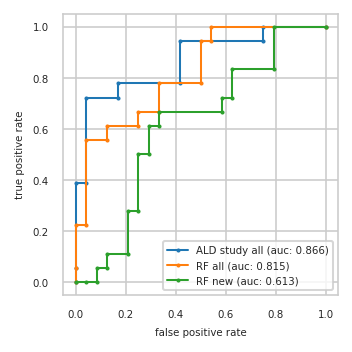

In [21]:
fig, ax = plt.subplots(1, 1, figsize=figsize)
plot_split_auc(results_ald_full.test, results_ald_full.name, ax)
plot_split_auc(results_model_full.test, results_model_full.name, ax)
plot_split_auc(results_model_new.test, results_model_new.name, ax)
fname = args.out_folder / 'auc_roc_curve.pdf'
files_out[fname.name] = fname
vaep.savefig(fig, name=fname)

Data used to plot ROC:

In [22]:
res = [results_ald_full, results_model_full, results_model_new]

auc_roc_curve = parse_roc(*res)
auc_roc_curve.to_excel(fname.with_suffix('.xlsx'))
auc_roc_curve

ALD study all       RF all       RF new      
             fpr   tpr    fpr   tpr    fpr   tpr
0          0.000 0.000  0.000 0.000  0.000 0.000
1          0.000 0.056  0.000 0.056  0.042 0.000
2          0.000 0.389  0.000 0.222  0.083 0.000
3          0.042 0.389  0.042 0.222  0.083 0.056
4          0.042 0.722  0.042 0.556  0.125 0.056
5          0.167 0.722  0.125 0.556  0.125 0.111
6          0.167 0.778  0.125 0.611  0.208 0.111
7          0.417 0.778  0.250 0.611  0.208 0.278
8          0.417 0.944  0.250 0.667  0.250 0.278
9          0.750 0.944  0.333 0.667  0.250 0.500
10         0.750 1.000  0.333 0.778  0.292 0.500
11         1.000 1.000  0.500 0.778  0.292 0.611
12           NaN   NaN  0.500 0.944  0.333 0.611
13           NaN   NaN  0.542 0.944  0.333 0.667
14           NaN   NaN  0.542 1.000  0.583 0.667
15           NaN   NaN  1.000 1.000  0.583 0.722
16           NaN   NaN    NaN   NaN  0.625 0.722
17           NaN   NaN    NaN   NaN  0.625 0.833
18           NaN   NaN    NaN   NaN  0.792 0.833
19           NaN   NaN    NaN   NaN  0.792 1.000
20           NaN   NaN    NaN   NaN  1.000 1.000

### Features selected for final models

In [23]:
selected_features = pd.DataFrame(
    [results_ald_full.selected_features,
     results_model_full.selected_features,
     results_model_new.selected_features],
    index=[
        results_ald_full.name,
        results_model_full.name,
        results_model_new.name]
).T
selected_features.index.name = 'rank'
fname = args.out_folder / 'mrmr_feat_by_model.xlsx'
files_out[fname.name] = fname
selected_features.to_excel(fname)
selected_features

,ALD study all,RF all,RF new
rank,,,
0,P10636-2;P10636-6,P10636-2;P10636-6,Q14894
1,F5H265,Q8NFY4;Q8NFY4-6,P36269;P36269-2;P36269-3
2,Q99969,A0A087X1T7;E7EX88;H0YM81;P16112;P16112-2,P30048;P30048-2
3,P61981,P00492,P31321
4,P04075,Q9Y2T3;Q9Y2T3-3,P10745
5,P14174,P61981,P51688
6,P00338;P00338-3,P04075,Q504Y2
7,P05160,P14174,Q96GD0
8,C9JF17;P05090,P63104,A0A075B7B8


### Precision-Recall plot on test data

vaep.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/prec_recall_curve.pdf


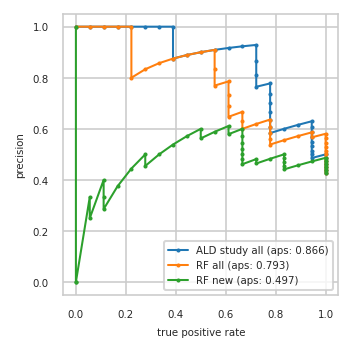

In [24]:
fig, ax = plt.subplots(1, 1, figsize=figsize)

ax = plot_split_prc(results_ald_full.test, results_ald_full.name, ax)
ax = plot_split_prc(results_model_full.test, results_model_full.name, ax)
ax = plot_split_prc(results_model_new.test, results_model_new.name, ax)
fname = folder = args.out_folder / 'prec_recall_curve.pdf'
files_out[fname.name] = fname
vaep.savefig(fig, name=fname)

Data used to plot PRC:

In [25]:
prec_recall_curve = parse_prc(*res)
prec_recall_curve.to_excel(fname.with_suffix('.xlsx'))
prec_recall_curve

ALD study all          RF all          RF new      
       precision   tpr precision   tpr precision   tpr
0          0.429 1.000     0.429 1.000     0.429 1.000
1          0.439 1.000     0.439 1.000     0.439 1.000
2          0.450 1.000     0.450 1.000     0.450 1.000
3          0.462 1.000     0.462 1.000     0.462 1.000
4          0.474 1.000     0.474 1.000     0.474 1.000
5          0.486 1.000     0.486 1.000     0.486 1.000
6          0.500 1.000     0.500 1.000     0.472 0.944
7          0.486 0.944     0.514 1.000     0.457 0.889
8          0.500 0.944     0.529 1.000     0.441 0.833
9          0.515 0.944     0.545 1.000     0.455 0.833
10         0.531 0.944     0.562 1.000     0.469 0.833
11         0.548 0.944     0.581 1.000     0.484 0.833
12         0.567 0.944     0.567 0.944     0.500 0.833
13         0.586 0.944     0.586 0.944     0.483 0.778
14         0.607 0.944     0.571 0.889     0.464 0.722
15         0.630 0.944     0.556 0.833     0.481 0.722
16         0.615 0.889     0.538 0.778     0.462 0.667
17         0.600 0.833     0.560 0.778     0.480 0.667
18         0.583 0.778     0.583 0.778     0.500 0.667
19         0.609 0.778     0.609 0.778     0.522 0.667
20         0.636 0.778     0.636 0.778     0.545 0.667
21         0.667 0.778     0.619 0.722     0.571 0.667
22         0.700 0.778     0.600 0.667     0.600 0.667
23         0.737 0.778     0.632 0.667     0.579 0.611
24         0.778 0.778     0.667 0.667     0.611 0.611
25         0.765 0.722     0.647 0.611     0.588 0.556
26         0.812 0.722     0.688 0.611     0.562 0.500
27         0.867 0.722     0.733 0.611     0.600 0.500
28         0.929 0.722     0.786 0.611     0.571 0.444
29         0.923 0.667     0.769 0.556     0.538 0.389
30         0.917 0.611     0.833 0.556     0.500 0.333
31         0.909 0.556     0.909 0.556     0.455 0.278
32         0.900 0.500     0.900 0.500     0.500 0.278
33         0.889 0.444     0.889 0.444     0.444 0.222
34         0.875 0.389     0.875 0.389     0.375 0.167
35         1.000 0.389     0.857 0.333     0.286 0.111
36         1.000 0.333     0.833 0.278     0.333 0.111
37         1.000 0.278     0.800 0.222     0.400 0.111
38         1.000 0.222     1.000 0.222     0.250 0.056
39         1.000 0.167     1.000 0.167     0.333 0.056
40         1.000 0.111     1.000 0.111     0.000 0.000
41         1.000 0.056     1.000 0.056     0.000 0.000
42         1.000 0.000     1.000 0.000     1.000 0.000

## Train data plots

vaep.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/prec_recall_curve_train.pdf


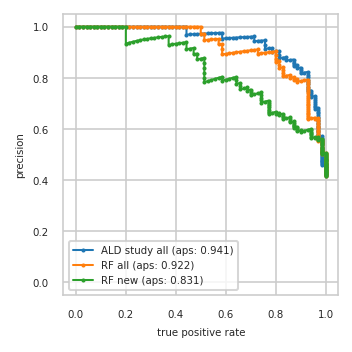

In [26]:
fig, ax = plt.subplots(1, 1, figsize=figsize)

ax = plot_split_prc(results_ald_full.train, results_ald_full.name, ax)
ax = plot_split_prc(results_model_full.train, results_model_full.name, ax)
ax = plot_split_prc(results_model_new.train, results_model_new.name, ax)
fname = folder = args.out_folder / 'prec_recall_curve_train.pdf'
files_out[fname.name] = fname
vaep.savefig(fig, name=fname)

vaep.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/auc_roc_curve_train.pdf


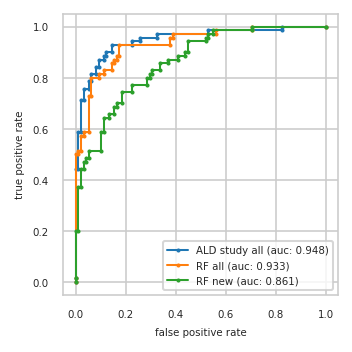

In [27]:
fig, ax = plt.subplots(1, 1, figsize=figsize)
plot_split_auc(results_ald_full.train, results_ald_full.name, ax)
plot_split_auc(results_model_full.train, results_model_full.name, ax)
plot_split_auc(results_model_new.train, results_model_new.name, ax)
fname = folder = args.out_folder / 'auc_roc_curve_train.pdf'
files_out[fname.name] = fname
vaep.savefig(fig, name=fname)

Output files:

In [28]:
files_out

{'results_RF all.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/results_RF all.pkl'),
 'results_RF new.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/results_RF new.pkl'),
 'results_ALD study all.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/results_ALD study all.pkl'),
 'auc_roc_curve.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/auc_roc_curve.pdf'),
 'mrmr_feat_by_model.xlsx': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/mrmr_feat_by_model.xlsx'),
 'prec_recall_curve.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/prec_recall_curve.pdf'),
 'prec_recall_curve_train.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/prec_recall_curve_train.pdf'),
 'auc_roc_curve_train.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/auc_roc_curve_train.pdf')}